In [ ]:
import pandas as pd
import numpy as np
import pickle
from textblob import TextBlob
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

### 1, Collect topic modeling and sentiment analysis data from part 1&2

In [ ]:
# Extract data of topic modelling results from part 1, sentiment result from part 2
# Due to limits of real-world data, we select time period from 2010 till 2019 which is 10 years

df = pd.DataFrame()

topic_category = pd.read_csv('results_topic modeling/topics_iphone_v2.csv', sep = ';', encoding="ISO-8859-1")

for year in range(2010,2020):

    # process results from part 1
    with open('results_topic modeling/lda_model_' + str(year) + '_v2_doc_topic_matrix.pkl', 'rb') as f:
      doc_topic = pickle.load(f)
    doc_topic = pd.DataFrame(doc_topic) # different number of topics every year
    top_cols = doc_topic.columns.to_list()

    # get topic categories and top index in this year
    topic_cat = topic_category[topic_category['year'] == year]
    for cat in topic_cat['topic_category'].unique():
      cat_year = topic_cat[topic_cat['topic_category'] == cat]
      topic_ind = cat_year['topic_index'].values
      doc_topic[cat] = doc_topic.loc[:,topic_ind].mean(axis = 1)     # aggregate by topic category

    # drop individiual topics, keep only topic categories
    doc_topic = doc_topic.drop(columns = top_cols)

    # assign link_id to each aggregated doc
    doc_list = pd.read_csv('results_topic modeling/' + str(year) + '_aggregated_posts_v2.csv', index_col= 0)
    doc_topic['link_id'] = doc_list['link_id']

    # process results from part 2
    sent_df = pd.read_csv('results_sentiment classification/sentiment_iphone' + str(year) + '_v2.csv', lineterminator='\n', low_memory = False)

    # also keep the 'created_utc' as timestamp data
    sent_df = sent_df[['link_id','created_utc','body','sentiment label','score']]

    # merge the data together by 'link_id' which stands for a same discussion
    df_merge = pd.merge(sent_df, doc_topic, on = 'link_id')
    df = pd.concat([df, df_merge], ignore_index = True)

    # fill NA as 0
    df = df.fillna(0)


### 2, Data processing for further analysis

2.1 Use an existing sentiment model Textblob as a comparison

In [ ]:
# Apply Sentiment Analysis: Use TextBlob to analyze the sentiment of each comment.
# TextBlob's sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity).
# The polarity score is a float within the range [-1.0, 1.0], where -1.0 is very negative,
# and 1.0 is very positive.

def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    return analysis.sentiment.polarity

# define a function to apply the sentiment polarity
def sentiment_TextBlob(df):

    # Apply the function to comments 'body'
    sentiment_results = df['body'].apply(analyze_sentiment)
    df['score_TextBlob'] = sentiment_results

    return df


In [ ]:
# Add sentiment result from Textblob

df = sentiment_TextBlob(df)

2.2 Further treatment against time stamp of 'creatd_utc', and the feature 'score' means how supportive of this post from other uses which is a good representitative of this KOL.aggregate the data frame into monthly form

In [ ]:
def feature_engineering(df):

    # Drop 'body' column to save ram
    df = df.drop(columns = ['body'])

    # Convert 'created_utc' to a datetime format
    df['created_date'] = pd.to_datetime(df['created_utc'])

    # Get the weighted sentiment by multiplying by score
    df['weighted_sent'] = df['sentiment label'] * df['score']
    df['weighted_sent_textblob'] = df['score_TextBlob'] * df['score']

    return df

In [ ]:
df = feature_engineering(df)

In [ ]:
def sentiment_agg_by_month(df):

    # Identify all topic related columns
    topic_columns = [col for col in df.columns[5:-5]]

    # Initial aggregation dictionary for mean of topics
    initial_agg_dict = {col: 'mean' for col in topic_columns}

    # First, group by 'link_id' and calculate mean of topic-related columns
    link_id_means = df.groupby('link_id').agg(initial_agg_dict).reset_index()

    # Merge the mean topic values back to the original dataframe
    df = df.merge(link_id_means, on='link_id', suffixes=('', '_mean'))

    # Now create an aggregation dictionary for the second aggregation
    agg_dict = {
        col + '_mean': 'first' for col in topic_columns  # Use 'first' to avoid re-calculating the mean
    }
    agg_dict.update({
        'weighted_sent': 'mean',
        'weighted_sent_textblob': 'mean',
        'Unnamed: 0': 'count'
    })

    # Resample by month and aggregate
    result = df.groupby([pd.Grouper(key='created_date', freq='M')]).agg(agg_dict)

    return result

In [ ]:
# Get aggregate result and list the posts number
df_agg_month = sentiment_agg_by_month(df)
df_agg_month.rename(columns = {'Unnamed: 0':'post_count'}, inplace = True)

### 3, Leverage real-world iPhone sales data

#### 3.1 The real world's data source come from 3rd party institution "Statistia", covering the accumulated sales volume in total of differen iPhone model types from 2010 - 2022 by month.

In [ ]:
#Extract sales volume of iPhone in the real world
sales_data = pd.read_excel('data/sales_volume.xlsx')

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Replacing NaN values with 0
sales_data.fillna(0, inplace=True)

# Ensure that all columns except 'iPhone Type' are numeric
for col in sales_data.columns:
    if col != 'iPhone Type':
        sales_data[col] = pd.to_numeric(sales_data[col], errors='coerce')

# Calculate the monthly sales
# Exclude the 'iPhone Type' column from the diff calculation
monthly_sales = sales_data.drop(columns=['iPhone Type']).diff(axis=1).fillna(0)

# Add the 'iPhone Type' column back to the monthly sales DataFrame
monthly_sales['iPhone Type'] = sales_data['iPhone Type']

# Transforming the data to use 'Year-Month' as the index
monthly_sales.set_index('iPhone Type', inplace=True)
monthly_sales = monthly_sales.transpose()
monthly_sales.index = pd.to_datetime(monthly_sales.index).to_period('M')

# keep the same time period with sentiment result time period
monthly_sales = monthly_sales[:-4]

<ipython-input-93-5e316ad0caa9>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  monthly_sales = sales_data.drop(columns=['iPhone Type']).diff(axis=1).fillna(0)


#### 3.2 To separate US region sales volume from others, we use approximate by calculate the sales revenue in US against whole as a ratio to represent the sales volume for every year. That is for months in one year, the ratio stay the same.

In [ ]:
## Given the approximate ratio of sales in American region by years

sale_us_ratio = [0.40, 0.35, 0.25, 0.22, 0.20, 0.18, 0.16, 0.15, 0.14, 0.14]
sale_us_ratio_by_month = [element for element in sale_us_ratio for _ in range(12)]

## Apply the ratio to each model type within time priod
for i in range(len(monthly_sales)):
    monthly_sales.iloc[i] = monthly_sales.iloc[i] * sale_us_ratio_by_month[i]

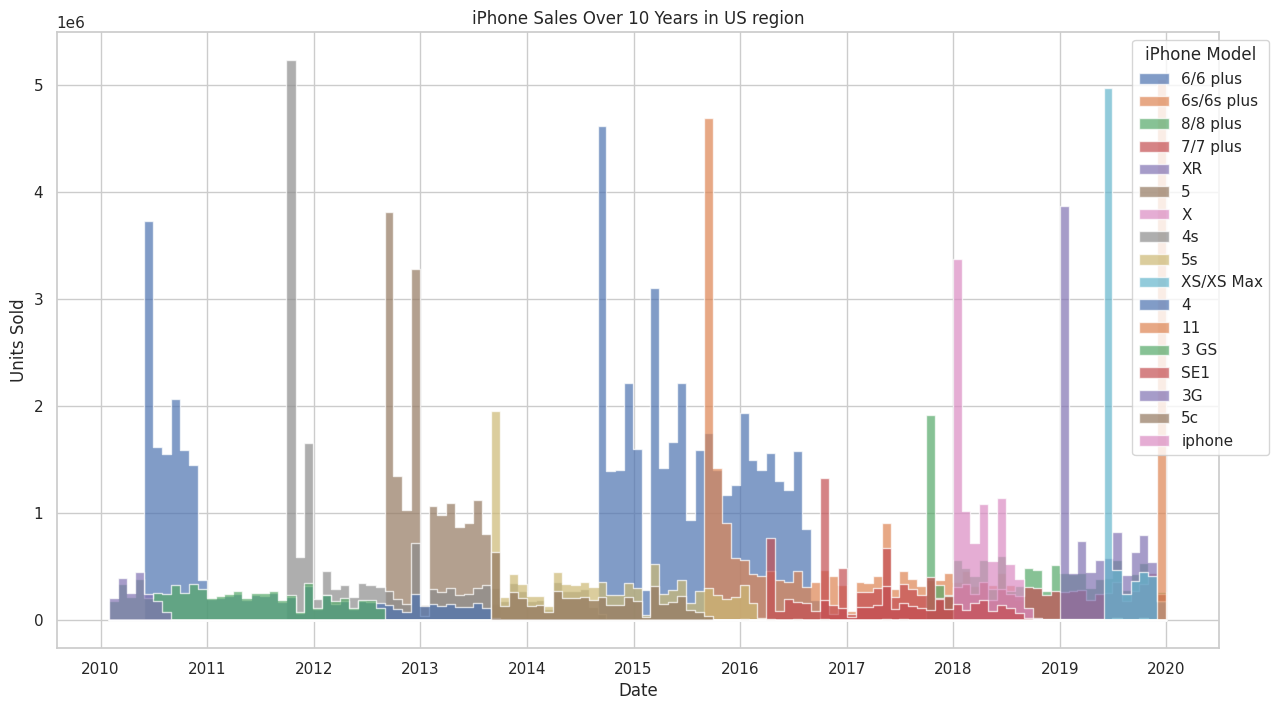

In [ ]:
# Preparing the data for a stacked area chart
plt.figure(figsize=(15, 8))

# List of models
models = monthly_sales.columns

# Plotting each model's sales
for model in models:
    plt.fill_between(monthly_sales.index.to_timestamp(freq='M', how='start'), monthly_sales[model], label=model, step="pre", alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title('iPhone Sales Over 10 Years in US region')
plt.legend(title='iPhone Model', bbox_to_anchor=(1.05, 1), loc='best')
#plt.tight_layout()
plt.show()

In [ ]:
# Line plot for total monthly sales
total_monthly_sales = monthly_sales.sum(axis=1)

## Merge sales figure to sentiment aggregated data
df_agg_month['sales'] = total_monthly_sales.values.astype(int)


3.3 Take into iPhone unit price as a feature

In [ ]:
# We take yearly sales revenue versus the sales units to estimate the unit price
# The unit price stay the same within one certain month
unit_price = [629.1, 634.9, 628.8, 607.2, 602.2, 670.4, 645.9, 651.6, 763.4, 760.1]

df_agg_month['unit_price'] = [element for element in unit_price for _ in range(12)]

### 4, Explotory Data Analysis


4.1 Trend line visualization

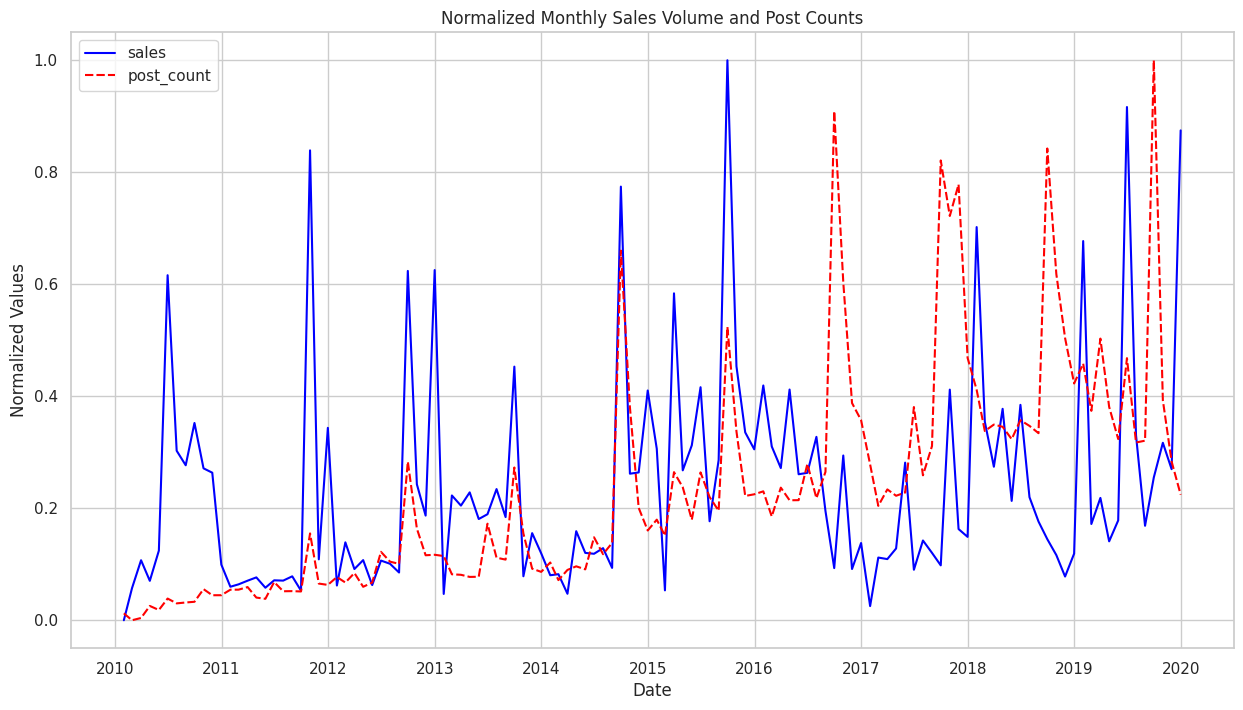

In [ ]:
df = df_agg_month

from sklearn.preprocessing import MinMaxScaler

# Normalizing the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[['sales', 'post_count']]), columns=['sales', 'post_count'], index=df.index)

# Add sentiment trend for comparsion
df_scaled['sentiment'] = scaler.fit_transform(df[['weighted_sent']])
df_scaled['sentiment_textblob'] = scaler.fit_transform(df[['weighted_sent_textblob']])
df_scaled['price'] = scaler.fit_transform(df[['unit_price']])

# Plotting the normalized data
plt.figure(figsize=(15, 8))
sns.lineplot(data=df_scaled[['sales', 'post_count']], palette=['blue', 'red'])

plt.title('Normalized Monthly Sales Volume and Post Counts')
plt.ylabel('Normalized Values')
plt.xlabel('Date')
plt.show()

In [ ]:
# for better visualization with sentiment results

def multi_comparison_chart(df):

    # define influencing factors
    factors = ['post_count','sentiment','sentiment_textblob','price']
    factor_index = 0

    # setup the plot
    fig, axs = plt.subplots(4, 1, figsize=(12,15))
    axs = axs.ravel()

    for ax in axs:

        # set target factor varible
        target_factor = factors[factor_index]
        ax.set_title(f"{target_factor} vs. sales volume")
        p1 = sns.barplot(ax=ax, x=df.index.strftime('%Y-%m'), y=target_factor, data=df, ci=None, color='lightgreen')

        # lower the density of time stamp
        for index, label in enumerate(p1.get_xticklabels()):
           if index % 3 == 0:
              label.set_visible(True)
           else:
              label.set_visible(False)

        # sales volume as a constant variable for comparsion
        ax2 = ax.twinx()
        p2 = sns.lineplot(ax=ax2, x=ax.get_xticks(), y="sales", data=df, color='blue')

        ax.set_xlabel("Year")
        ax.set_ylabel(f"Normalized {target_factor} Value")
        ax.tick_params(axis="x", rotation=45)
        ax.legend([target_factor], loc = 'upper left')
        ax2.legend(['sales'], loc = 'best')

        factor_index += 1

    fig.tight_layout()

    return


<ipython-input-100-50a506093dbf>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p1 = sns.barplot(ax=ax, x=df.index.strftime('%Y-%m'), y=target_factor, data=df, ci=None, color='lightgreen')
<ipython-input-100-50a506093dbf>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p1 = sns.barplot(ax=ax, x=df.index.strftime('%Y-%m'), y=target_factor, data=df, ci=None, color='lightgreen')
<ipython-input-100-50a506093dbf>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p1 = sns.barplot(ax=ax, x=df.index.strftime('%Y-%m'), y=target_factor, data=df, ci=None, color='lightgreen')
<ipython-input-100-50a506093dbf>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  p1 = sns.barplot(ax=ax, x=df.index.strftime('%Y-%m'), y=target_factor, data=df, ci=None, color='lightgreen')


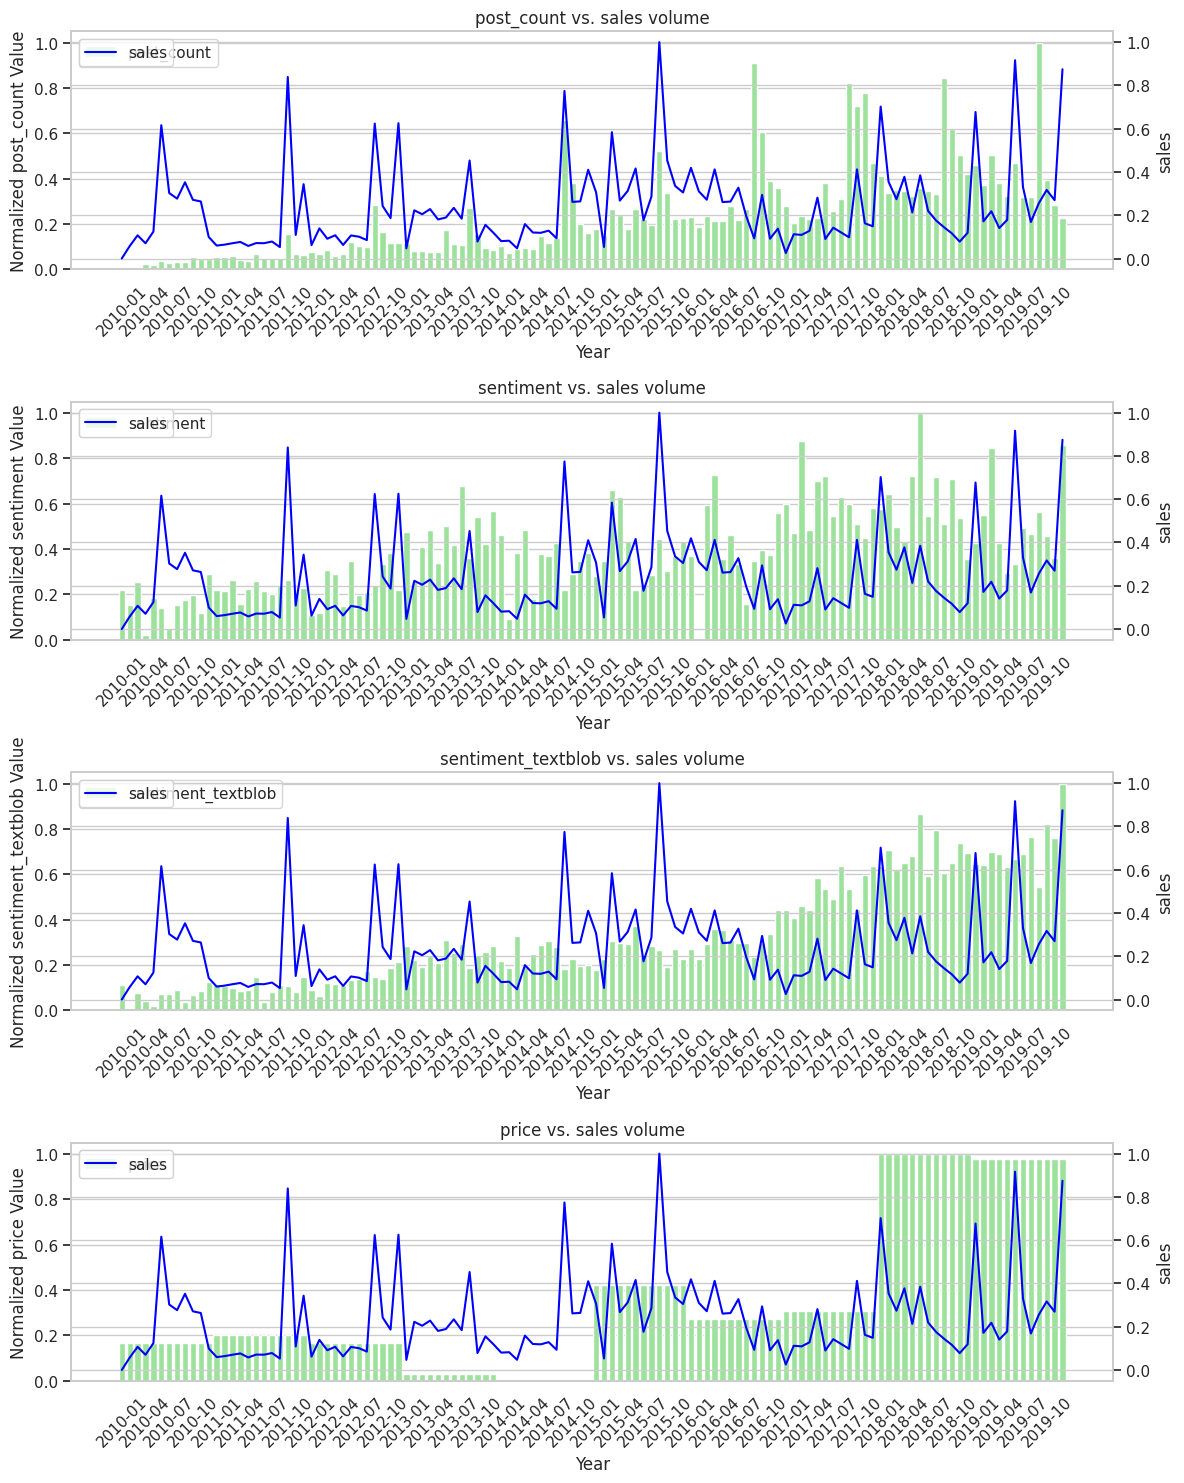

In [ ]:
multi_comparison_chart(df_scaled)

4.3 Time Series Analysis


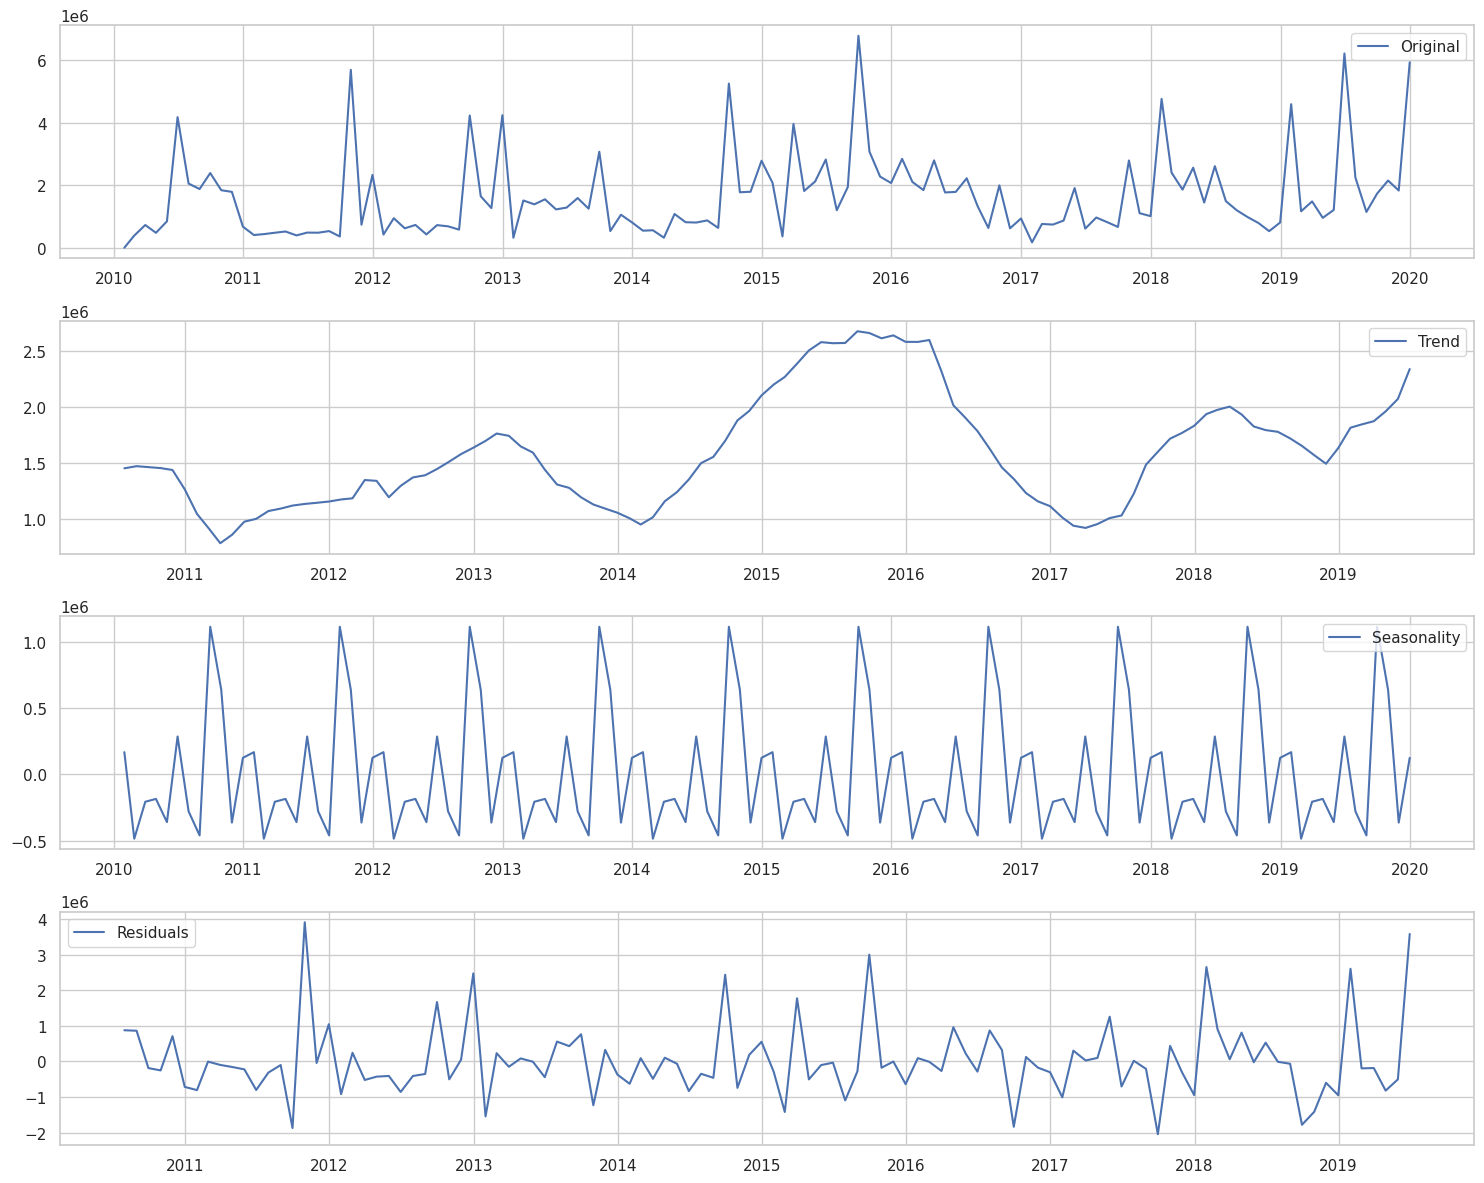

In [ ]:
# The trend chart looks hard to find any relationship.
# To further explore if iPhone sales have seasonal effects like black Friday or certain new product launch season
# we will do seasonal decomposition to find any patterns

# Seasonal Decompose
decomposition = sm.tsa.seasonal_decompose(df['sales'], model='additive')

# Extracting the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotting the decomposed components
plt.figure(figsize=(15, 12))

plt.subplot(411)
plt.plot(df['sales'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


4.4 GDP growth rate as a potention confounding factor

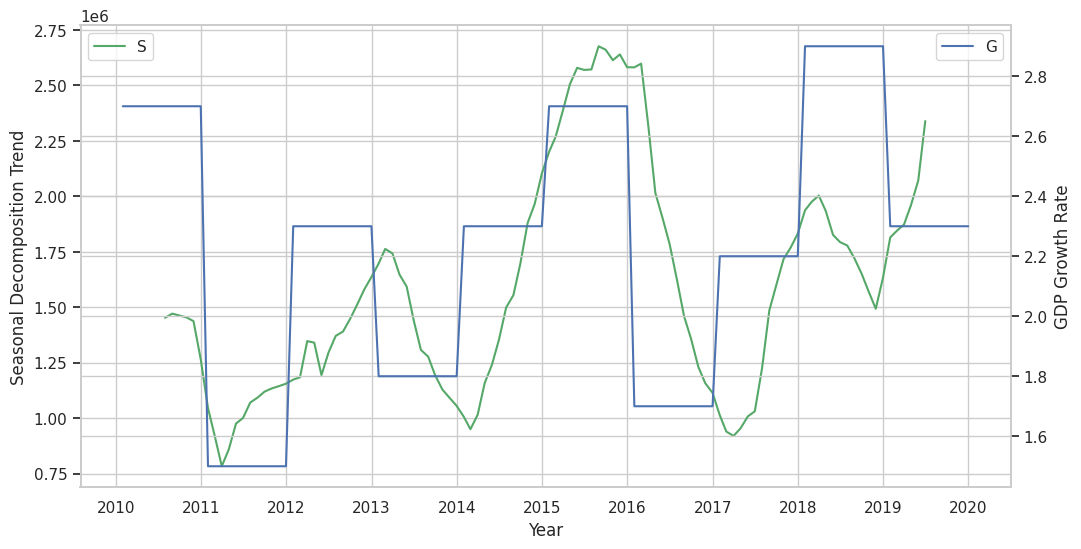

In [ ]:
# We will take the GDP growth rate as a potential confounding factor will might generate some impact on iPhone sales volume.
# Statistic is from 3rd party institute "Statitia"
annual_gdp_growth_rate = [2.70, 1.50, 2.30, 1.80, 2.30, 2.70, 1.70, 2.20, 2.90, 2.30]
df_agg_month['gdp']= [element for element in annual_gdp_growth_rate for _ in range(12)]

fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.plot(trend, color='g')
ax2.plot(df_agg_month['gdp'], color='b')

ax1.set_xlabel('Year')
ax1.set_ylabel('Seasonal Decomposition Trend')
ax2.set_ylabel('GDP Growth Rate')

ax1.legend('Sales Trend',loc='upper left')
ax2.legend('GDP growth',loc='upper right')

plt.show()

### 5, Correlation Analysis

In [ ]:
# add time trend from simplified series from 1 to 120
df['time']= [x for x in range(120)]

In [ ]:
# First, we will use multiple regression including confounding factors like GDP, price

# Preparing the data (topics prevelance will also be included)
X = df.drop(columns = ['sales', 'weighted_sent_textblob'])  # All related independent variables
y = df['sales']  # Dependent variable

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit()

# Printing the summary of the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.9408
Date:                Mon, 11 Dec 2023   Prob (F-statistic):              0.519
Time:                        04:42:44   Log-Likelihood:                -1856.0
No. Observations:                 120   AIC:                             3742.
Df Residuals:                     105   BIC:                             3784.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

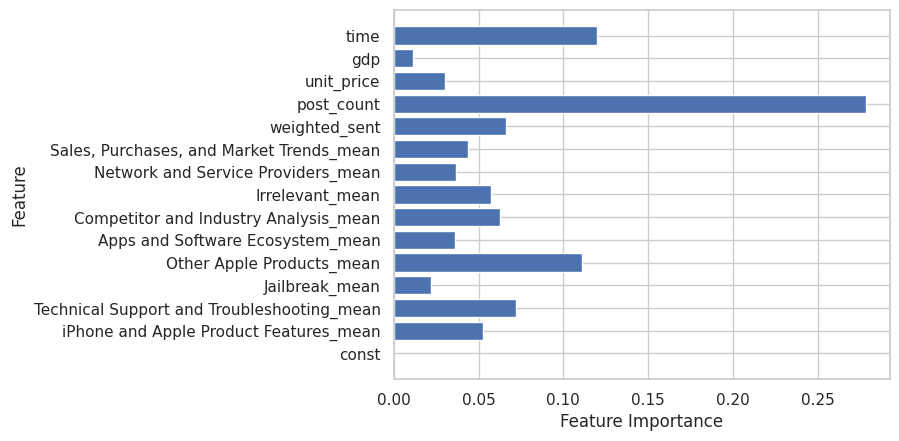

In [ ]:
# Random Forest for feature importance
# X = X.drop(columns = ['weighted_sent_textblob'])  # exclude result of textblob
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
plt.barh(X.columns, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.show()

### 6, Predictive Modelling

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features (important for regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ridge Regression with GridSearchCV for hyperparameter tuning
parameters = {'alpha': [0.01, 0.1, 1, 10, 100]}
ridge_reg = Ridge(random_state=0)
clf = GridSearchCV(ridge_reg, parameters, scoring='neg_root_mean_squared_error', cv=5)
clf.fit(X_train_scaled, y_train)

# Best model
best_ridge = clf.best_estimator_

# Cross-validated RMSE
cv_rmse = -cross_val_score(best_ridge, X_train_scaled, y_train, scoring='neg_root_mean_squared_error', cv=5).mean()
print("Cross-Validated RMSE:", cv_rmse)

# Predict and Evaluate on Test Set
y_pred = best_ridge.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", test_rmse)


Cross-Validated RMSE: 1336369.3999402951
Test RMSE: 1169051.1524883283
